# Simulating protocol 3, cell 5

In this notebook, I'll use Michaels method 3 parameters to simulate protocol 3 and get synthetic data similar to the real data for cell 5. 

To get an idea on how I compared the multiple parameter sets check the norebook called Kylie..._synth_parameterExplo_notebook...

All the data files are in my OneDrive at: /OneDrive .../Postdoc/cardiacNoiseData, but I'll add some of the data here in folder Some_Kilies_data/
There is a readme.txt file explaining what is in each file, including the names of the protocols and a dictionary of cell's names.  Protocols 3-5 are big files to have in github. Protocl 7 is the sine wave data, and protocol 6 is the action potential data. The protocols that I have the myokit version are 2, 3, 4, 5

- First load the data
- compare ODE solution and data
- check if the estimate for N matches the new parameters
- simulate synt data

In [1]:
# Libraries

import matplotlib.pyplot as plt
import numpy as np
import myokit
import myokit.lib.markov
from scipy.interpolate import interp1d

## Meta parameters

In [2]:
times_to_skip = 50 
NumExpo_flag = True # We will use 4 exponentials
saved_splines = False
#FileNameSplines = 'protocol3_cell5_splines_params_largerCurrents.npy' 
#FileNameSplinesWeights = 'protocol3_cell5_splines_params_largerCurrents_weights.npy'
if saved_splines:
    print('This code will load the splines parameters instead of fitting them')

## Load the data and simulate it

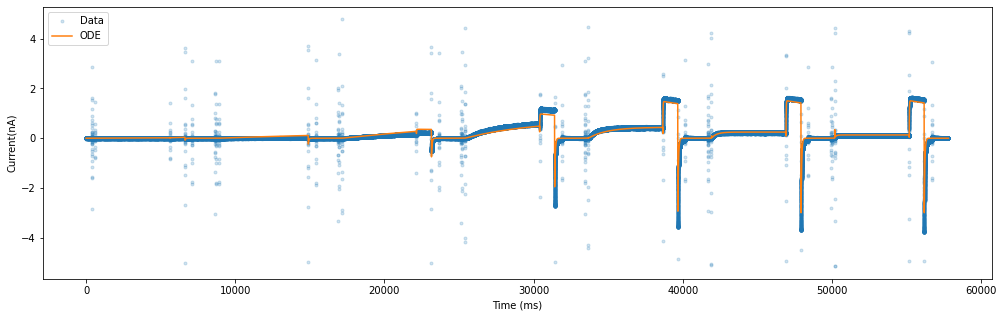

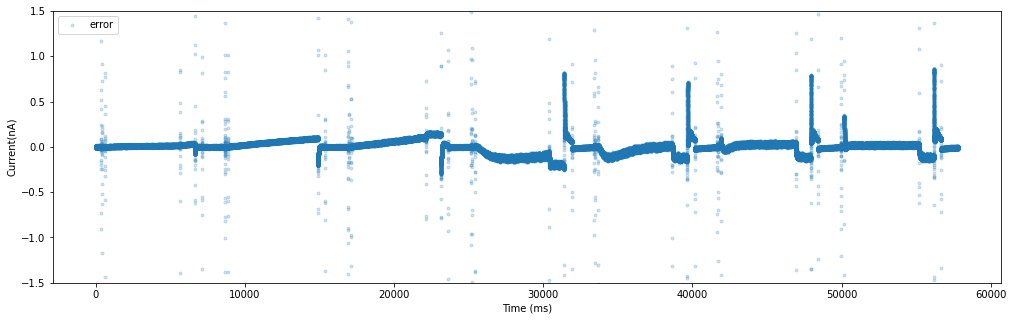

In [3]:
# Load the data
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)

# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov-M-M3.mmt')
# Load a protocols
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')
#protocol_5 = myokit.load_protocol('resources/pr5-deactivation.mmt')

# Create a parametrisable Hodgkin-Huxley model
parameters = [
    'ikr.p1', 
    'ikr.p2', 
    'ikr.p3', 
    'ikr.p4', 
    'ikr.p5', 
    'ikr.p6', 
    'ikr.p7', 
    'ikr.p8', 
    'ikr.p9',
]
markov_model = myokit.lib.markov.LinearModel.from_component(model.get('ikr'), parameters=parameters)
# Create an analytical simulation 
markov_sim_pr3 = myokit.lib.markov.AnalyticalSimulation(markov_model, protocol_3)
# Log times will be equal to the times from the data
hh_log_pr3 = markov_sim_pr3.run(pr3_time[-1] + 0.1, log_times=pr3_time)


plt.figure(figsize=(17, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current(nA)')
plt.plot(pr3_time, pr3_current, '.', alpha = 0.2,label='Data')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr'], '-', label='ODE')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(17, 5))
plt.xlabel('Time (ms)')
plt.ylabel('Current(nA)')
plt.plot(pr3_time, hh_log_pr3['ikr.IKr']-pr3_current, '.', alpha = 0.2, label='error')
plt.legend(loc='upper left')
plt.ylim([-1.5,1.5])
plt.show()


## Stochastic simulation

For the parameters from Michael M3, the corresponding N is:

$$N = \frac{G_{kr}}{g_{kr}} = \frac{0.133898 \mu S}{2\text{ or } 13.5 pS}.$$
So, 
$$N_U = 66 949, \quad N_l = 9 918$$

I'll simulate:
$$N_U = 70000, \quad N_l = 10000$$ 

In [4]:
# Parameters
N_lower = 10000
N_upper = 70000
seed_m = 1


# define the simulations and simualte
np.random.seed(seed_m)
sim_pr3_N_lower = myokit.lib.markov.DiscreteSimulation(markov_model, protocol_3, nchannels = N_lower)
sim_pr3_N_upper = myokit.lib.markov.DiscreteSimulation(markov_model, protocol_3, nchannels = N_upper)
print('Running simulation for N_l = ', N_lower)
log_pr3_N_lower = sim_pr3_N_lower.run(pr3_time[-1] + 0.1)
print('N_l DONE')

print('Running simulation for N_U = ', N_upper)
log_pr3_N_upper = sim_pr3_N_upper.run(pr3_time[-1] + 0.1)
print('N_U DONE')



Running simulation for N_l =  10000


In [ ]:
# Save the opening and current track, and separated them into the same time steps as the data
print('Interpolating for N_l')
O_pr3_N_lower = np.array(log_pr3_N_lower['ikr.y3']) 
I_pr3_N_lower = np.array(log_pr3_N_lower['ikr.IKr'])
time_full_pr3_N_lower = np.array(log_pr3_N_lower['engine.time'])
O_inter = interp1d(time_full_pr3_N_lower, O_pr3_N_lower,'previous', fill_value = "extrapolate")
O_grid_pr3_N_lower = O_inter(pr3_time)
I_inter = interp1d(time_full_pr3_N_lower, I_pr3_N_lower,'previous', fill_value = "extrapolate")
I_grid_pr3_N_lower = I_inter(pr3_time)


print('Interpolating for N_U')
O_pr3_N_upper = np.array(log_pr3_N_upper ['ikr.y3']) 
I_pr3_N_upper = np.array(log_pr3_N_upper['ikr.IKr'])
time_full_pr3_N_upper = np.array(log_pr3_N_upper['engine.time'])
O_inter = interp1d(time_full_pr3_N_upper, O_pr3_N_upper,'previous', fill_value = "extrapolate")
O_grid_pr3_N_upper = O_inter(pr3_time)
I_inter = interp1d(time_full_pr3_N_upper, I_pr3_N_upper,'previous', fill_value = "extrapolate")
I_grid_pr3_N_upper = I_inter(pr3_time)


print('hola')

## Separate by voltage and define color scheme

In [4]:
# Define the steps of the protocol
pr3_Vtimes = (np.array(protocol_3.log_for_interval(0,pr3_time[-1] + 0.1)['time'])*10)
pr3_Vtimes = pr3_Vtimes.astype(np.int32)

pr3_current_constV = {}
pr3_current_constV_without_first5ms = {}
pr3_time_constV_without_first5ms = {}
for i in range(len(pr3_Vtimes)-1):
    pr3_current_constV[i]= pr3_current[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]
    pr3_current_constV_without_first5ms[i] = pr3_current[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
    pr3_time_constV_without_first5ms[i] = pr3_time[pr3_Vtimes[i] + times_to_skip:(pr3_Vtimes[i+1]-1)]
print(len(pr3_current_constV))

# Voltages
pr3_voltage_constV = pr3_voltage[pr3_Vtimes[:-1]]
pr3_unique_Vs, pr3_unique_Vs_1stUindex, pr3_unique_Vs_index= np.unique(pr3_voltage_constV, return_index = True, return_inverse = True)

# Colors & labels long
#pr3_unique_Vs_colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9']
#pr3_unique_Vs_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']
pr3_unique_Vs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
pr3_voltage_constV_colors = []
pr3_voltage_constV_labels_full = []
for i in range(len(pr3_unique_Vs_index)):
    pr3_voltage_constV_colors.append(pr3_unique_Vs_colors[pr3_unique_Vs_index[i]])
    pr3_voltage_constV_labels_full.append('V ='+str(pr3_unique_Vs[pr3_unique_Vs_index[i]]))

# Labels simple
pr3_voltage_constV_labels_simple = np.repeat('_nolegend_', len(pr3_unique_Vs_index))
for i in range(len(pr3_unique_Vs_1stUindex)):
    pr3_voltage_constV_labels_simple[pr3_unique_Vs_1stUindex[i]] = 'V ='+str(pr3_unique_Vs[i])

42
